# Biweekly Report 7

## Deep Fool

### Logan Barnhart

In this notebook we'll be taking a look at Deep Fool, an algorithm designed to distort images in a way that makes them highly uninterpretable to humans but yields a high confidence prediction from a model. 

This is a way to test the robustness of a model

We'll be using the official code used in the report from https://github.com/LTS4/DeepFool/blob/master/Python/test_deepfool.py 

and some help from https://pytorch.org/vision/stable/models.html#classification for how to use loaded models 

## Introduction

While deep nueral networks can manage some impressive tasks, they are 'fooled' more easily than one might expect. Until recently there was no surefire way to test the robustness of a model to gauge how easily it might be fooled. The deep fool algorithm was designed with this intent in mind. 

The deep fool algorithm alters images in minor ways to have a model incorrectly classify said image. Moreover, it maintains high confidence in the prediction and can even estimate what the new prediction will be. 

At a very high level, the algorithm works by adjusting pixel values in a way that places the image data across the nearest decision boundary. While that explanation doesn't really do it justice, it's the simplest way to summarize the alterations in high dimensional spaces with highly nonlinear decision boundaries.

The following [image](https://drive.google.com/file/d/1PYkUMmlDYNfPlFYf11ArkOGFo49qbGnK/view?usp=share_link) represents a simple linear decision boundary for a binary classifier. The algorithm works by 'moving' the sample $x_0$ across the decision boundary along the shortest path possible. 

Okay, hopefully that made some sense, but even if it didn't it's not fully necessary and things should clear up as we move through the report!


## Loading a model

We need a model to fool in the first place, so let's work with one of the last ones we learned about in the classification unit: ShuffleNet. 

I don't need to train the model so I'll be loading the pretrained one provided by torchvision. 

In [1]:
import torch
import torch.nn as nn
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt


In [2]:
weights = models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1 # info about the trained model
shufflenet = models.shufflenet_v2_x0_5(weights = weights) # model architecture loaded with weights

Let's also import all the labels and the images we'll be using while we're at it. We only need to use a few examples to see how deep fool works, so I just chose 4 images I like from the dataset. 

In [4]:
labels = open(os.path.join('imagenet1k_labels.txt'), 'r').read().split('\n')
images = []
images += [Image.open('/content/n02489166_proboscis_monkey.jpeg')]
images += [Image.open('/content/n02490219_marmoset.jpeg')]
images += [Image.open('/content/n02494079_squirrel_monkey.jpeg')]
images += [Image.open('/content/n02509815_lesser_panda.jpeg')]
true_labels = ['proboscis_monkey', 'marmoset', 'squirrel_monkey', 'lesser_panda']

### Visualizing the Images

Let's quickly take a look at the pictures

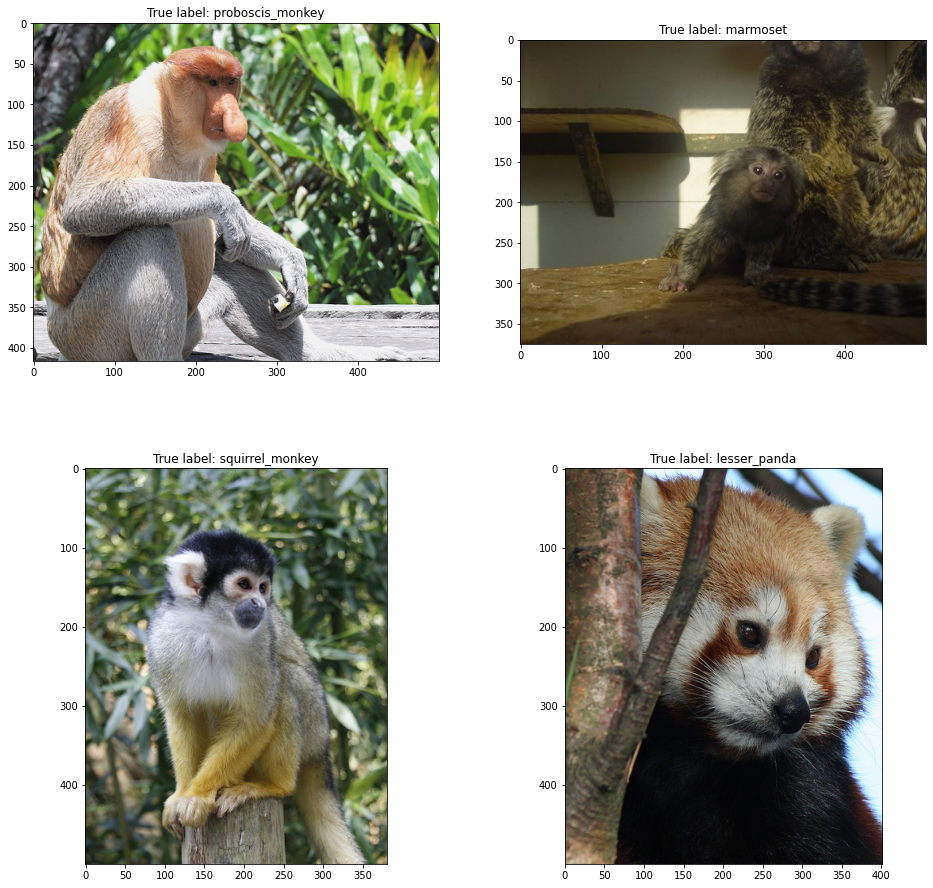

In [5]:
fig, ax = plt.subplots(2,2, figsize = (16,16))
ax[0][0].imshow(images[0])
ax[0][0].set_title("True label: " + true_labels[0])
ax[0][1].imshow(images[1])
ax[0][1].set_title("True label: " + true_labels[1])
ax[1][0].imshow(images[2])
ax[1][0].set_title("True label: " + true_labels[2])
ax[1][1].imshow(images[3])
ax[1][1].set_title("True label: " + true_labels[3])
plt.show()


This model is reported to have 60% 1st place accuracy in the documentation, so let's verify if it can correctly classify any of these. 

proboscis monkey: 100.0%
marmoset: 98.4%
squirrel monkey: 99.3%
lesser panda: 100.0%


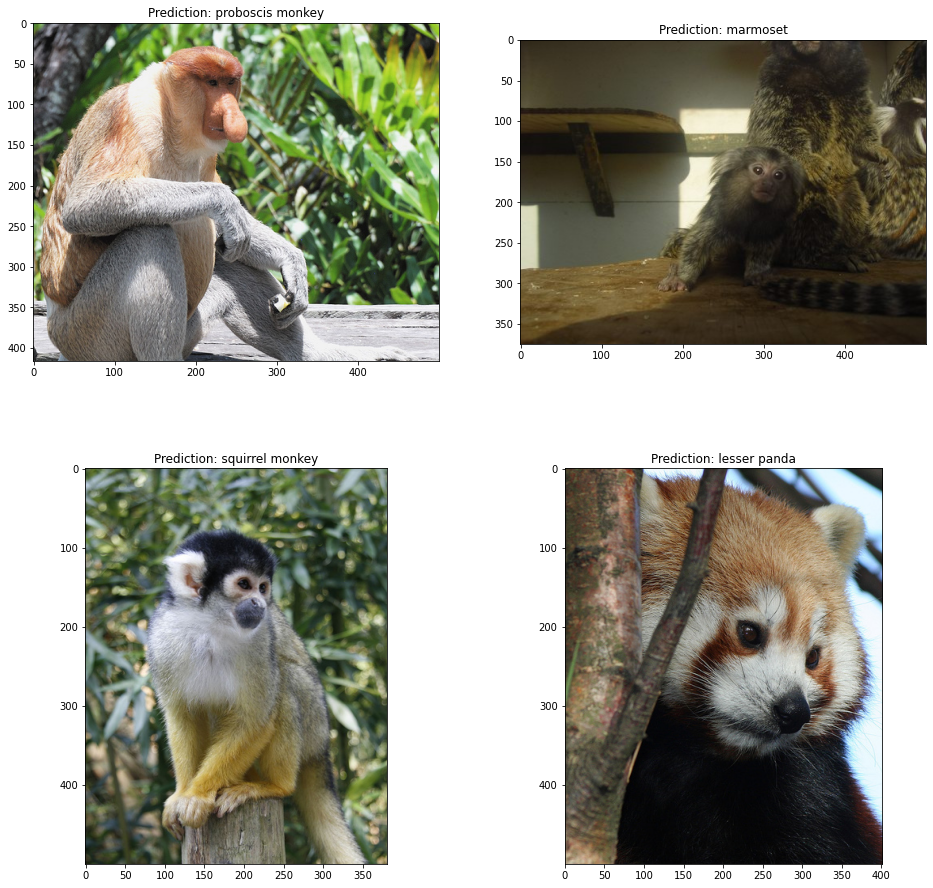

In [6]:
# Initialize the preprocessing transforms
preprocess = weights.transforms()

fig, ax = plt.subplots(2,2, figsize = (16,16))
fax = ax.ravel() # unravel axes so we can plot in all spots with just 1 dimension, easier in for loops

for idx, img in enumerate(images):
  # apply preprocessing to image
  batch = preprocess(img).unsqueeze(0)

  # Use the model and print the predicted category
  prediction = shufflenet(batch).squeeze(0).softmax(0)
  class_id = prediction.argmax().item() # predicted label id
  score = prediction[class_id].item() # model's confidence in prediction
  category_name = weights.meta["categories"][class_id] # predicted label as string
  fax[idx].imshow(img)
  fax[idx].set_title('Prediction: ' + weights.meta["categories"][class_id])
  print(f"{category_name}: {100 * score:.1f}%")

Perfect, these are some great images with correct and high confidence labelings, hopefully deep fool can break this!

## Deep Fooling the Model

Below is the official code used in the deep fool paper; it's quite dense and since it's not as simple as 'moving' an image to the closest decision boundary, the math behind it can be hard to digest and would require thorough elaboration that I simply cannot do as well as the paper, so if you're interested please go read it for more details!


In [7]:
import numpy as np
from torch.autograd import Variable
import copy
import torchvision.transforms as transforms

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    is_cuda = torch.cuda.is_available()

    if is_cuda:
        print("Using GPU")
        image = image.cuda()
        net = net.cuda()
    else:
        print("Using CPU")


    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = Variable(pert_image[None, :], requires_grad=True)
    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        # Added 1e-4 for numerical stability
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        if is_cuda:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
        else:
            pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

        x = Variable(pert_image, requires_grad=True)
        fs = net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

We'll just take what they do above with a grain of salt - now we want to run the algorithm on our images and save the perturbed and estimated labels.

Using CPU


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


Using CPU


Using CPU


Using CPU


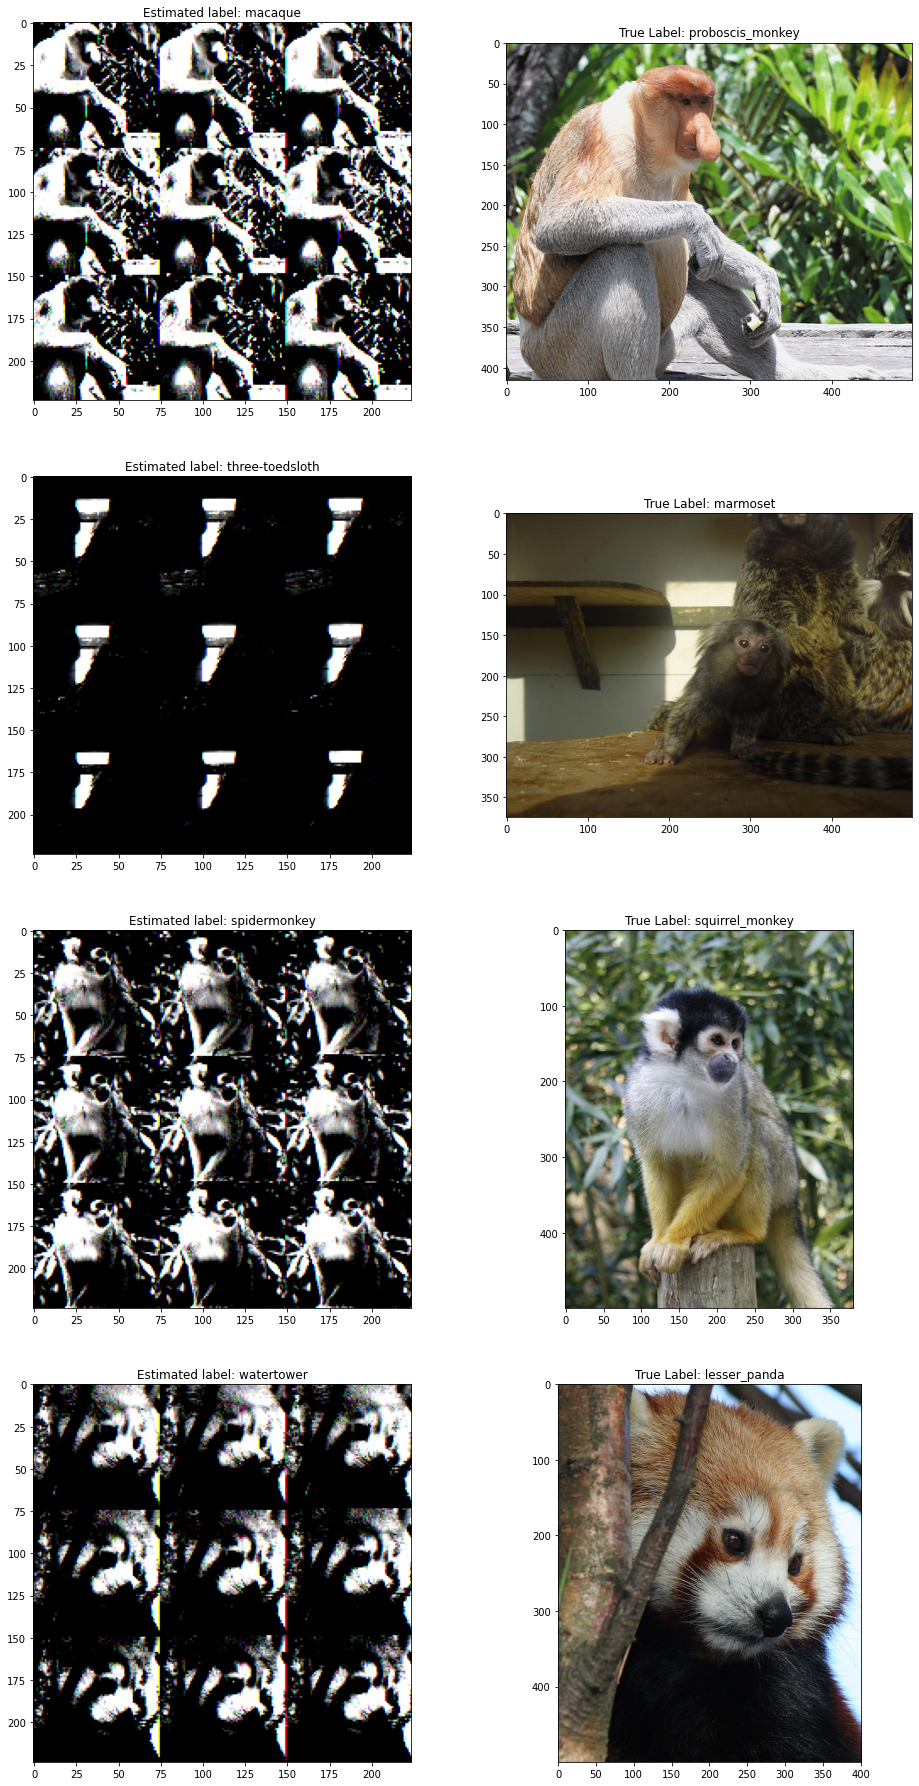

In [18]:
altered_images = []
altered_labels_est = []

fig, ax = plt.subplots(4,2, figsize = (16,32))

for i in range(4):

  im = preprocess(images[i]) # images mnust be preprocessed already for the algorithm

  r, loop_i, label_orig, label_pert, pert_image = deepfool(im, shufflenet) # run deepfool
  pert_image = pert_image[0].reshape((224,224,3)) # reshape to correct dims. 
  altered_images.append(pert_image)

  str_label_pert = ''.join(labels[np.int(label_pert)].split(',')[0].split(' ')[1:]) # get the estimated label
  altered_labels_est.append(str_label_pert)

  # plot new image with estimated label and original image / label
  ax[i][0].imshow(pert_image)
  ax[i][0].set_title("Estimated label: " + str_label_pert)
  ax[i][1].imshow(images[i])
  ax[i][1].set_title("True Label: " + true_labels[i])
plt.show()

Now lets see how dramatically these alterations changes the predictions

In [44]:
# format things nicely
print('   Label Predicted    |   Confidence   |   Label Estimated   |   True Label')
print('    by ShuffleNet     |                |     by Deep Fool    |             ')

#iterate through perturbed images and predict
for idx, img in enumerate(altered_images):
  ## need to fix the shape again to predict
  batch = img.reshape((3,224,224)) 
  batch = batch.unsqueeze(0)
  prediction = shufflenet(batch).squeeze(0).softmax(0) # run prediction
  class_id = prediction.argmax().item()
  score = prediction[class_id].item()
  category_name = weights.meta["categories"][class_id]
  #Print nicely 
  print(f"{category_name:>16}", '     |', f"     {100 * score:.1f}     ", '|', f"{altered_labels_est[idx]:>16}", '   |', f"{true_labels[idx]:>12}")

   Label Predicted    |   Confidence   |   Label Estimated   |   True Label
    by ShuffleNet     |                |     by Deep Fool    |             
         macaque      |      49.8      |          macaque    | proboscis_monkey
three-toed sloth      |      48.3      |  three-toedsloth    |     marmoset
   spider monkey      |      48.9      |     spidermonkey    | squirrel_monkey
     water tower      |      45.5      |       watertower    | lesser_panda


##Conclusions

Fantastic, these are exactly the results we'd expect! Although it's not the near 100% confidence we saw with the original images, 50% confidence on a dataset with 1000 classes is still *very* confident, much better than random. On top of the high confidence predictions, deep fool correctly estimated the label that our model would predict! 

I just find that really fascinating and a great tool as deep learning continues to develop. I can imagine that as deep neural networks become more and more integrated in our lives, robustness is going to be incredibly important. Something like this deep fool algorithm could evolve into some kind of exploit for certain models in the future.